In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/who-is-the-real-winner/sample_submission.csv
/kaggle/input/who-is-the-real-winner/train.csv
/kaggle/input/who-is-the-real-winner/test.csv


In [3]:
train_file_path= '../input/who-is-the-real-winner/train.csv'
test_file_path= '../input/who-is-the-real-winner/test.csv'

train_data=pd.read_csv(train_file_path,index_col="ID")
test_data=pd.read_csv(test_file_path,index_col="ID")

columns_drop=['Candidate','Constituency ∇']
train_data.drop(columns=columns_drop, inplace=True)
test_data.drop(columns=columns_drop, inplace=True)

train_data.head()

,Party,Criminal Case,Total Assets,Liabilities,state,Education
ID,,,,,,
0,DMK,4,211 Crore+,2 Crore+,TAMIL NADU,8th Pass
1,BJP,0,1 Crore+,0,MADHYA PRADESH,12th Pass
2,INC,0,7 Crore+,22 Lac+,KARNATAKA,Post Graduate
3,BJP,0,9 Crore+,24 Lac+,BIHAR,Post Graduate
4,BJP,2,2 Crore+,61 Lac+,WEST BENGAL,8th Pass


In [4]:
y=train_data.Education
y.head()

ID
0         8th Pass
1        12th Pass
2    Post Graduate
3    Post Graduate
4         8th Pass
Name: Education, dtype: object

In [5]:
train_data.drop(columns=['Education'], inplace=True)
train_data.head()

,Party,Criminal Case,Total Assets,Liabilities,state
ID,,,,,
0,DMK,4,211 Crore+,2 Crore+,TAMIL NADU
1,BJP,0,1 Crore+,0,MADHYA PRADESH
2,INC,0,7 Crore+,22 Lac+,KARNATAKA
3,BJP,0,9 Crore+,24 Lac+,BIHAR
4,BJP,2,2 Crore+,61 Lac+,WEST BENGAL


In [6]:
def convert_to_numeric(value_str):
    if 'Crore' in value_str:
        return float(value_str.split(' ')[0]) * 1e7
    elif 'Lac' in value_str:
        return float(value_str.split(' ')[0]) * 1e5
    elif 'Thou' in value_str:
        return float(value_str.split(' ')[0]) * 1e3
    elif 'Hund' in value_str:
        return float(value_str.split(' ')[0]) * 1e2
    else:
        return float(value_str)
    

train_data['Total Assets'] = train_data['Total Assets'].apply(convert_to_numeric)
train_data['Liabilities'] = train_data['Liabilities'].apply(convert_to_numeric)
test_data['Total Assets'] = test_data['Total Assets'].apply(convert_to_numeric)
test_data['Liabilities'] = test_data['Liabilities'].apply(convert_to_numeric)

train_data.head()

,Party,Criminal Case,Total Assets,Liabilities,state
ID,,,,,
0,DMK,4,2.110000e+09,20000000.0,TAMIL NADU
1,BJP,0,1.000000e+07,0.0,MADHYA PRADESH
2,INC,0,7.000000e+07,2200000.0,KARNATAKA
3,BJP,0,9.000000e+07,2400000.0,BIHAR
4,BJP,2,2.000000e+07,6100000.0,WEST BENGAL


In [7]:
encoded_train_data = pd.get_dummies(train_data, columns=['Party', 'state'])
encoded_test_data = pd.get_dummies(test_data, columns=['Party', 'state'])
encoded_train_data.head()

,Criminal Case,Total Assets,Liabilities,Party_AAP,Party_AIADMK,Party_AITC,Party_BJD,Party_BJP,Party_CPI,Party_CPI(M),...,state_ODISHA,state_PUDUCHERRY,state_PUNJAB,state_RAJASTHAN,state_SIKKIM,state_TAMIL NADU,state_TRIPURA,state_UTTAR PRADESH,state_UTTARAKHAND,state_WEST BENGAL
ID,,,,,,,,,,,,,,,,,,,,,
0,4,2.110000e+09,20000000.0,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0,1.000000e+07,0.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,7.000000e+07,2200000.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,9.000000e+07,2400000.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2,2.000000e+07,6100000.0,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True


In [8]:
from sklearn.model_selection import train_test_split

# Splitting the encoded data into features (X) and target variable (y)
X = encoded_train_data  # Features

# Splitting the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Define and initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust parameters as needed

# Train the Random Forest model using your training data (replace X_train and y_train with your actual training data)
rf_model.fit(X_train, y_train)

# Make predictions on the validation data
val_predictions_rf = rf_model.predict(X_val)

# Calculate the F1 score on the validation data
f1_rf = f1_score(y_val, val_predictions_rf, average='weighted')

print("F1 Score (Random Forest) on Validation Data:", f1_rf)

# Make predictions on the test data
test_predictions_rf = rf_model.predict(encoded_test_data)

# If you want to calculate the F1 score on test data as well (replace encoded_test_data with your actual test data)
# Ensure that the number of samples in test data matches the number of samples used during model training
# Calculate the F1 score on the test data
# f1_rf_test = f1_score(true_labels_test, test_predictions_rf, average='weighted')

# print("F1 Score (Random Forest) on Test Data:", f1_rf_test)







F1 Score (Random Forest) on Validation Data: 0.1862606483311826


In [10]:


print("Predicted Education Values for Test Data:")
print(test_predictions_rf)


Predicted Education Values for Test Data:
['Graduate' '8th Pass' 'Graduate' ... 'Post Graduate' 'Post Graduate'
 'Post Graduate']


In [11]:
submission_df = test_data
submission_df['Education'] = test_predictions_rf
submission_df['ID'] = submission_df.index
submission_df[['ID','Education']].to_csv('submission.csv', index=False)

print("Submission file 'submission.csv' created successfully!")















Submission file 'submission.csv' created successfully!


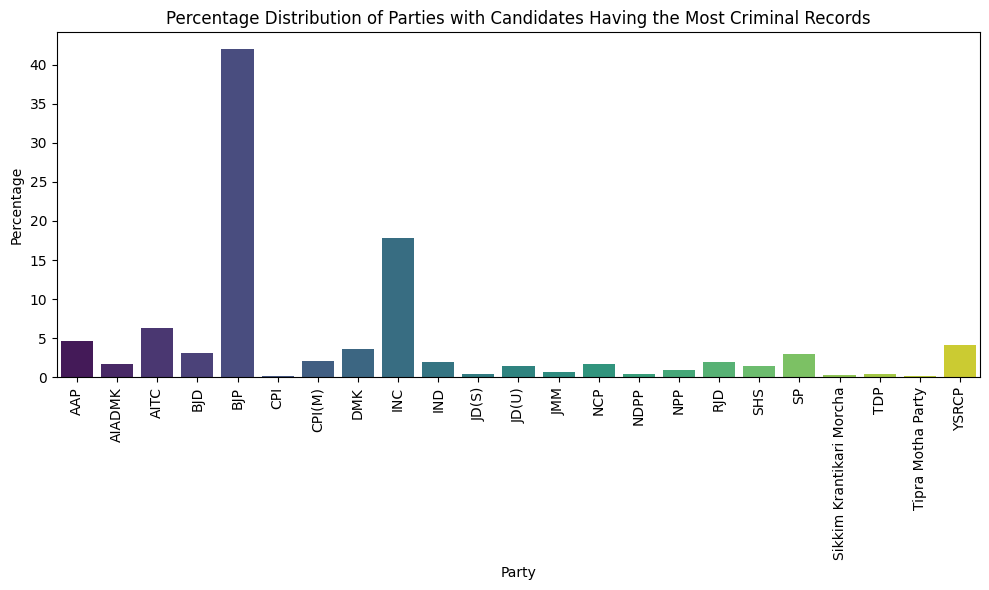

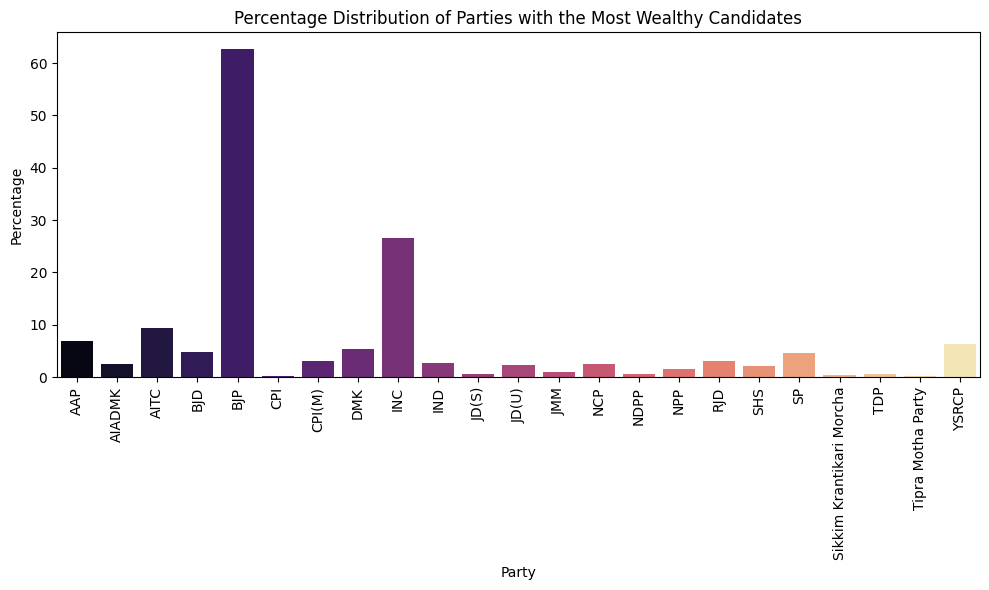

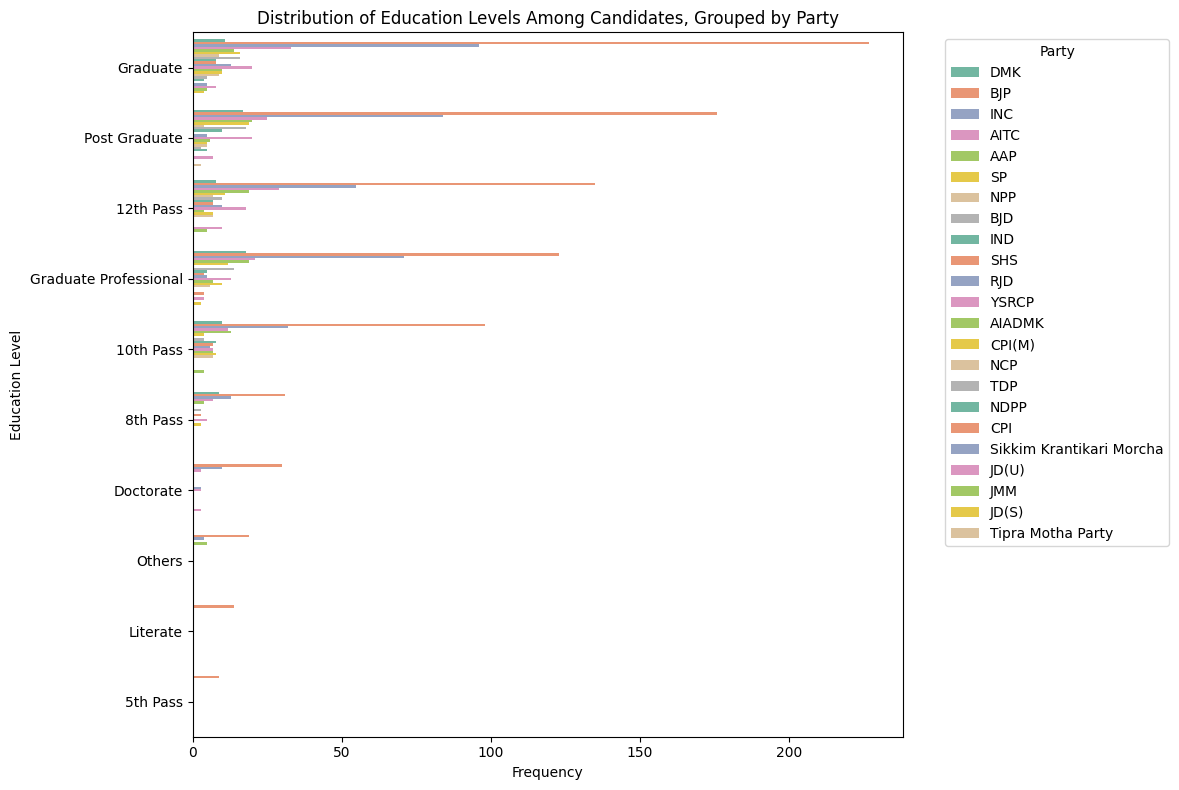

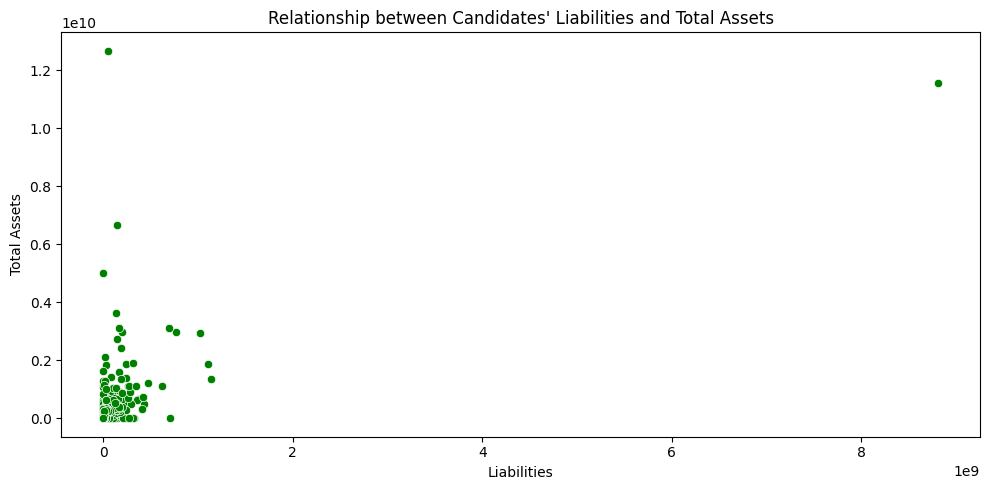

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the percentage distribution of parties with candidates having the most criminal records
criminal_records = test_data.groupby('Party')['Criminal Case'].max().reset_index()
party_counts = test_data['Party'].value_counts().reset_index()
party_counts.columns = ['Party', 'Count']
criminal_records = pd.merge(criminal_records, party_counts, on='Party')
criminal_records['Percentage'] = (criminal_records['Count'] / len(test_data)) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x='Party', y='Percentage', data=criminal_records, palette='viridis')
plt.title("Percentage Distribution of Parties with Candidates Having the Most Criminal Records")
plt.xlabel("Party")
plt.ylabel("Percentage")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plotting the percentage distribution of parties with the most wealthy candidates
wealthy_candidates = train_data.groupby('Party')['Total Assets'].max().reset_index()
party_counts = train_data['Party'].value_counts().reset_index()
party_counts.columns = ['Party', 'Count']
wealthy_candidates = pd.merge(wealthy_candidates, party_counts, on='Party')
wealthy_candidates['Percentage'] = (wealthy_candidates['Count'] / len(test_data)) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x='Party', y='Percentage', data=wealthy_candidates, palette='magma')
plt.title("Percentage Distribution of Parties with the Most Wealthy Candidates")
plt.xlabel("Party")
plt.ylabel("Percentage")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Plotting the distribution of education levels among the candidates, grouped by party
plt.figure(figsize=(12, 8))
sns.countplot(y=y, hue=train_data['Party'], order=y.value_counts().index, palette='Set2')
plt.title("Distribution of Education Levels Among Candidates, Grouped by Party")
plt.xlabel("Frequency")
plt.ylabel("Education Level")
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Plotting the relationship between candidates' liabilities and total assets
plt.figure(figsize=(10, 5))
sns.scatterplot(x=train_data['Liabilities'], y=train_data['Total Assets'], color='green')
plt.title("Relationship between Candidates' Liabilities and Total Assets")
plt.xlabel("Liabilities")
plt.ylabel("Total Assets")
plt.tight_layout()
plt.show()
